# Comparing Cs D1 Transitions

This brief example will calculate the absorption of a weak probe in a vapor of Cs pumped by a stronger pump beam. 
Both are tuned to the D1 line for a specific polarization that is specified below. We want to compare absorption as a function of magnetic field for the four transitions of the D1 line. 

## Julia Environment
First we must set up the Julia environment. In particular, we must download the OpticalBlochEquations package from GitHub and add it to our environment. We can run the built-in tests, if we wish. After that, we will add a number of other packages that we will need to display the data. 

In [1]:
using Pkg
Pkg.activate("myEnvironment")

  Activating new project at `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment`


In [3]:
ENV["JULIA_SSL_CA_ROOTS_PATH"]=""

""

In [5]:
Pkg.add(url="https://github.com/floriansLU/OpticalBlochEquations.jl")

     Cloning git-repo `https://github.com/floriansLU/OpticalBlochEquations.jl`
    Updating git-repo `https://github.com/floriansLU/OpticalBlochEquations.jl`
   Resolving package versions...
   Installed libdecor_jll ──────────────────────── v0.2.2+0
   Installed libfdk_aac_jll ────────────────────── v2.0.3+0
   Installed OrdinaryDiffEqRKN ─────────────────── v1.1.0
   Installed Libmount_jll ──────────────────────── v2.40.3+0
   Installed JpegTurbo_jll ─────────────────────── v3.1.1+0
   Installed GR_jll ────────────────────────────── v0.73.13+0
   Installed OffsetArrays ──────────────────────── v1.15.0
   Installed OrdinaryDiffEqStabilizedRK ────────── v1.1.0
   Installed HypergeometricFunctions ───────────── v0.3.27
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.6.0
   Installed LERC_jll ──────────────────────────── v4.0.1+0
   Installed StatsFuns ─────────────────────────── v1.3.2
   Installed FFTW ──────────────────────────────── v1.8.1
   Installed Accessors ───────────────

In [7]:
Pkg.test("OpticalBlochEquations")

     Testing OpticalBlochEquations
      Status `C:\Users\User\AppData\Local\Temp\jl_ftuNBb\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [8bb1440f] DelimitedFiles v1.9.1
  [057dd010] FastTransforms v0.17.0
  [2604418b] OpticalBlochEquations v1.1.0-DEV `https://github.com/floriansLU/OpticalBlochEquations.jl#master`
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.40.9
  [6e0679c1] QuantumOptics v1.2.2
  [295af30f] Revise v3.7.2
  [87c4ff3e] WignerD v0.1.4
  [9f57e263] WignerSymbols v2.0.0
  [8ba89e20] Distributed v1.11.0
  [37e2e46d] LinearAlgebra v1.11.0
  [2f01184e] SparseArrays v1.11.0
  [8dfed614] Test v1.11.0
      Status `C:\Users\User\AppData\Local\Temp\jl_ftuNBb\Manifest.toml`
  [47edcb42] ADTypes v1.13.0
  [621f4979] AbstractFFTs v1.5.0
  [7d9f7c33] Accessors v0.1.41
  [79e6a3ab] Adapt v4.2.0
  [66dad0bd] AliasTables v1.1.3
  [ec485272] ArnoldiMethod v0.4.0
⌅ [7d9fca2a] Arpack v0.5.3
  [4fba245c] ArrayInterface v7.18.0
  [4c555306] ArrayLayouts v1.11.1
  [aae01518] B

In [9]:
Pkg.add("BenchmarkTools");
Pkg.add("Plots");
Pkg.add("PlotlyBase");
Pkg.add("PlotlyKaleido");
Pkg.add("Profile");
Pkg.add("DataFrames");
Pkg.add("CSV");
using Distributed;
addprocs(Sys.CPU_THREADS);
using BenchmarkTools;
using OpticalBlochEquations;
using DataFrames;
using CSV;
using Plots;
plotly();

   Resolving package versions...
    Updating `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  [91a5bcdd] + Plots v1.40.9
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
   Installed PlotlyBase ─ v0.8.20
    Updating `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  [a03496cd] + PlotlyBase v0.8.20
    Updating `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
  [a03496cd] + PlotlyBase v0.8.20
Precompiling project...
   5205.3 ms  ✓ PlotlyBase
   3415.2 ms  ✓ PlotlyBase → DistributionsExt
  2 dependencies successfully pre

## Defining the parameters
Now we set up the calculation. The function `param(cesiumD1)` defines the quantum numbers of the ground and excited states of the Cesium D1 line and create a structure that contain all the necessary operators. The function laser creates a structure for the Rabi frequency, natural line width, transit relaxation, laser frequency, laser linewidth, temperature, atomic mass, and other constants.  

The interation of the atomic dipole with the electric field of the light is given by: 

$\hat{V}=-\hat{\mathbf{d}}\cdot\hat{\mathbf{E}}(t)$

The electric field is given by

$\hat{\mathbf{E}}(t)=\varepsilon(t)\mathbf{\epsilon} + \varepsilon^{*}(t)\mathbf{\epsilon^{*}}$

where $\epsilon$ is the polarization vector and 

$\varepsilon(t)=| \varepsilon_{\overline{\omega}}|e^{i\Phi(t)-i(\overline{\omega}-\mathbf{k}_{\overline{\omega}}\cdot \mathbf{v})t}$,

where $\varepsilon_{\overline{\omega}}$ is the amplitude,$\Phi(t)$ is a, possibly, time-dependent phase, $\overline{\omega}$ is the frequency of the light, $\mathbf{k}_{\overline{\omega}}$ is the wave vector of the light, and $\mathbf{v}$ is the velocity of the atom that interacts with the light.    

The polarization is defined using spherical polarization vectors. The spherical polarization vectors correspond to light that is left-circularly polarized ($\epsilon^{+1}$), linearly polarized along the $z$-direction ($\epsilon^{0}$), or right-circularly polarized ($\epsilon^{-1}$):. 

$\epsilon^{+1} = -\frac{1}{\sqrt{2}}\left( \epsilon_x -i \epsilon_y \right)$

$\epsilon^{0} = \epsilon_z$

$\epsilon^{-1} = \frac{1}{\sqrt{2}}\left( \epsilon_x +i \epsilon_y \right)  $

where $\epsilon_q$, $q \in \{x,y,z\}$ are the polarization vector's projection onto the Cartesian coordinate axes. 

Thus, \[1,0,0] would correspond to left-circularly polarized light with electric field vector rotating in the $xy$-plane, \[0,1,0] to light that is linearly polarized along the $z$-axis, and \[0,0,1] would correspond to right-circularly polarized light with the electric-field vector rotating in the $xy$-plane.  

We can rotate into an arbitrary coordinate system using the Euler angles $\alpha$, $\beta$, and $\gamma$. Thus, for example, we could start with linearly polarized light \[0,1,0] and rotate it by $\beta=\pi /2$ into the $xy$-plane to obtain counter-rotating left- and right-circularly polarized light. 

We define a range of magnetic field values over which we want to calculate. 

For more details on the polarization, see the following:

\[1]  M. Auzinsh, D. Budker, S. Rochester, Optically Polarized Atoms: Understanding Light-atom Interactions, OUP Oxford, 2010.

\[2] D. A. Varshalovich, A. N. Moskalev, V. K. Khersonskii, [Quantum Theory of Angular Momentum](https://library.oapen.org/handle/20.500.12657/50493), World Scientific Co. Pte. Ltd., Singapore, 2011.


In [11]:
par = param(cesiumD1)
laz = laser(ω_bar = 335120562.8)  # 3-->3 transition
e_vec_i = ElectricVector([0,1,0], 0, π / 2, pi/2).cyclic
e_vec_n = ElectricVector([0,1,0], 0, π / 2, π / 2).cyclic
e_vec_z = ElectricVector([0,1,0], 0, π / 2, π / 4).cyclic
evecs=(e_vec_i,e_vec_n,e_vec_z)
Doppler_steps=150
laz.Ωᵣ
Brange=[-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
laz

laser
  Ωᵣ: ComplexF64
  Γ: ComplexF64
  γ: ComplexF64
  ω_bar: Float64 3.351205628e8
  Δω: Float64 4.0
  kB: Float64 1.3806503999999998e-23
  T: Float64 298.0
  mass: Float64 2.2062111060000003e-25
  c: Float64 2.99792458e8
  muB_MHz: Float64 1.3996


In [13]:
res33=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(res33,result)
end

x33=Brange
myResults=reshape(res33,(4,25))
y33=myResults[2,:] |> real;

Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


## Plotting the results
For each magnetic field value, the results are given in a `tuple` that contains the fluorescence fom the pump beam, the absorption of the probe beam, the ground-state density matrix, and the excited-state density matrix, in that order. In this case, the probe absorption has been unpacked, and it is plotted below. 



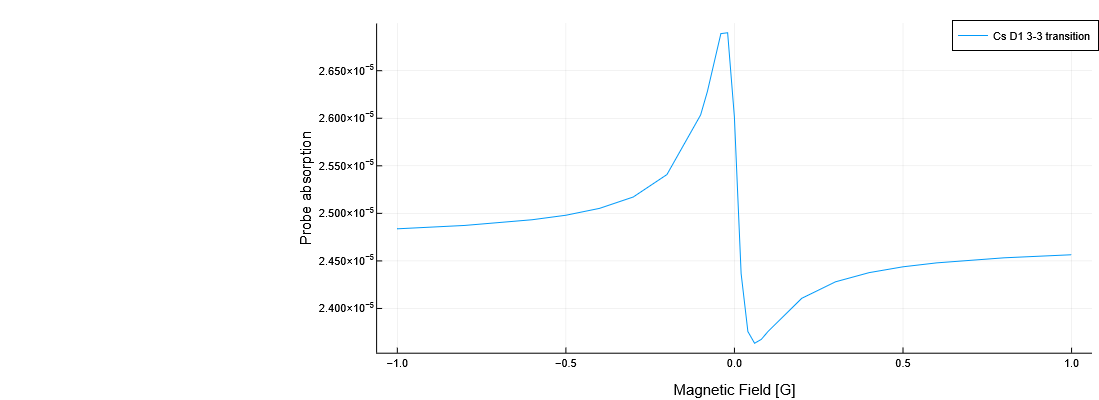

In [29]:
df33=DataFrame(B=x33,Absorption=y33)
CSV.write("CsD1_33_Omega1.csv",df33)
plot(x33,y33,xlabel="Magnetic Field [G]",ylabel="Probe absorption",label="Cs D1 3-3 transition")

In [17]:
laz = laser(ω_bar = 335121730.5)   # Fg=3-->Fe=4 transition 3.3512173052281266e8
res34=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(res34,result)
end

x34=Brange
myResults=reshape(res34,(4,25))
y34=myResults[2,:] |> real;

Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


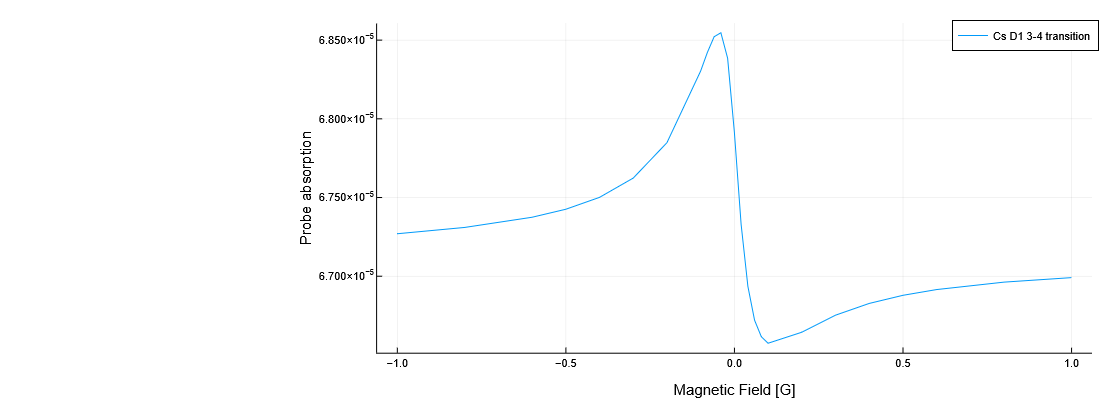

In [31]:
df34=DataFrame(B=x34,Absorption=y34)
CSV.write("CsD1_34_Omega1.csv",df34)
plot(x34,y34,xlabel="Magnetic Field [G]",ylabel="Probe absorption",label="Cs D1 3-4 transition")

In [23]:
laz = laser(ω_bar = 335112537.89104265)   # Fg=4-->Fe=4 transition 335112537.89104265 
res44=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(res44,result)
end

x44=Brange
myResults=reshape(res44,(4,25))
y44=myResults[2,:] |> real;

Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


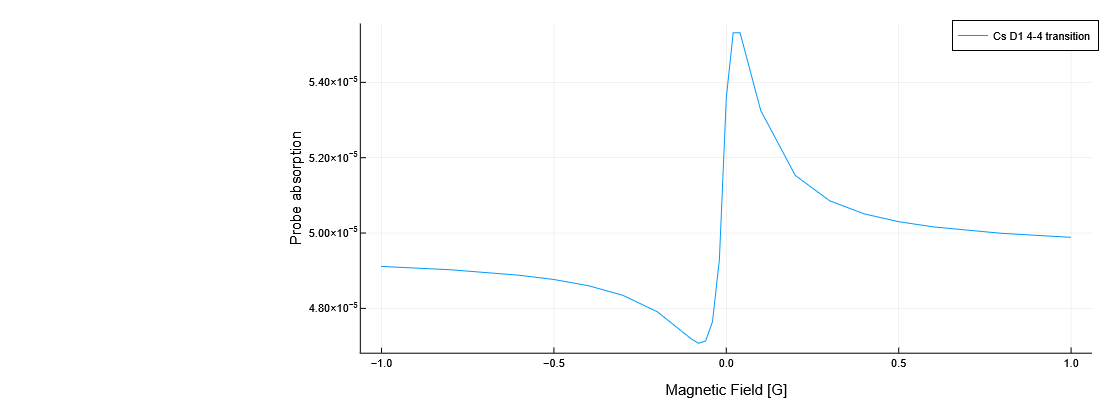

In [26]:
df44=DataFrame(B=x44,Absorption=y44)
CSV.write("CsD1_44_Omega1.csv",df44)
plot(x44,y44,xlabel="Magnetic Field [G]",ylabel="Probe absorption",label="Cs D1 4-4 transition")

In [25]:
laz = laser(ω_bar = 335111370.21028066)   # Fg=4-->Fe=3 transition  3.3511137021028066e8
res43=[]
for B₀ in Brange
    result=signals(B₀, par, laz, evecs, Doppler_steps)
    append!(res43,result)
end

x43=Brange
myResults=reshape(res43,(4,25))
y43=myResults[2,:] |> real;

Processing magnetic field B₀=-1.0 G.
Processing magnetic field B₀=-0.8 G.
Processing magnetic field B₀=-0.6 G.
Processing magnetic field B₀=-0.5 G.
Processing magnetic field B₀=-0.4 G.
Processing magnetic field B₀=-0.3 G.
Processing magnetic field B₀=-0.2 G.
Processing magnetic field B₀=-0.1 G.
Processing magnetic field B₀=-0.08 G.
Processing magnetic field B₀=-0.06 G.
Processing magnetic field B₀=-0.04 G.
Processing magnetic field B₀=-0.02 G.
Processing magnetic field B₀=0.0 G.
Processing magnetic field B₀=0.02 G.
Processing magnetic field B₀=0.04 G.
Processing magnetic field B₀=0.06 G.
Processing magnetic field B₀=0.08 G.
Processing magnetic field B₀=0.1 G.
Processing magnetic field B₀=0.2 G.
Processing magnetic field B₀=0.3 G.
Processing magnetic field B₀=0.4 G.
Processing magnetic field B₀=0.5 G.
Processing magnetic field B₀=0.6 G.
Processing magnetic field B₀=0.8 G.
Processing magnetic field B₀=1.0 G.


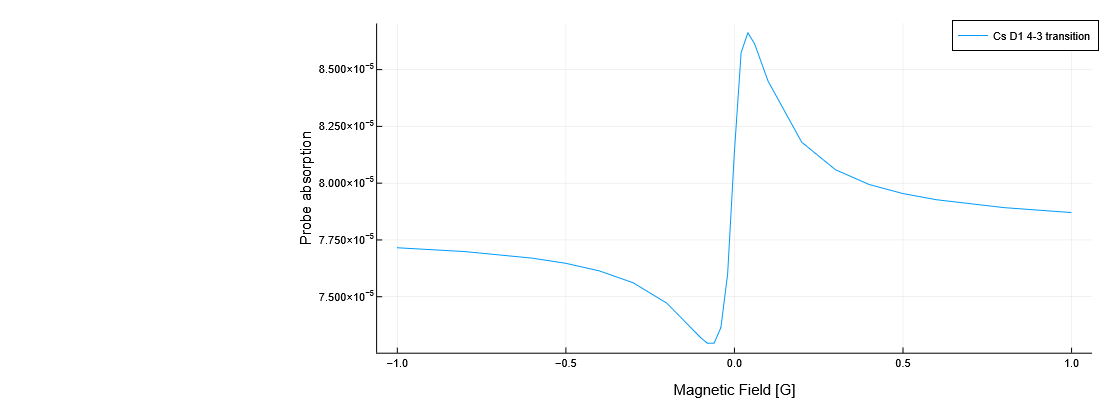

In [33]:
df43=DataFrame(B=x43,Absorption=y43)
CSV.write("CsD1_43_Omega1.csv",df43)
plot(x43,y43,xlabel="Magnetic Field [G]",ylabel="Probe absorption",label="Cs D1 4-3 transition")

## Comparison
Having calculated and plotted the absorption separately for each transition, we can now normalize them and plot them on one graph. 

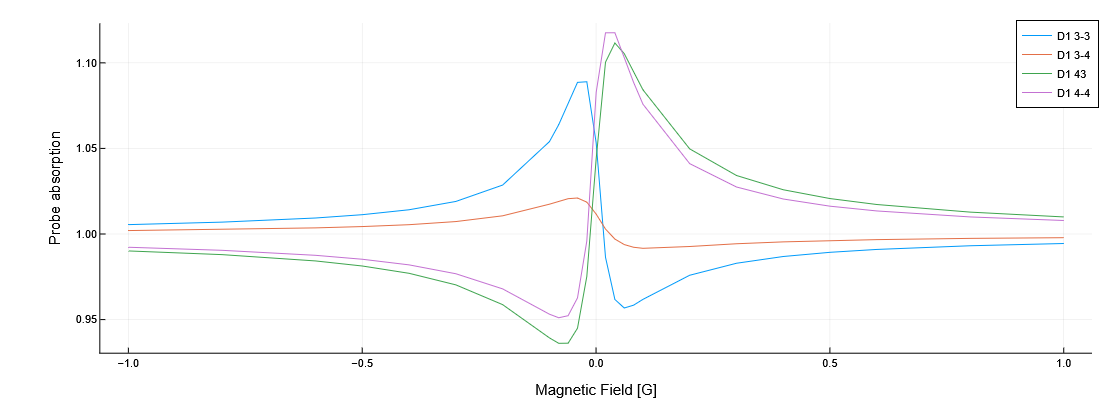

In [37]:
y33norm=y33./((y33[begin]+y33[end])/2.0)
y34norm=y34./((y34[begin]+y34[end])/2.0)
y43norm=y43./((y43[begin]+y43[end])/2.0)
y44norm=y44./((y44[begin]+y44[end])/2.0)
plot([x33 x34 x43 x44], [y33norm y34norm y43norm y44norm],xlabel="Magnetic Field [G]",ylabel="Probe absorption",label=["D1 3-3" "D1 3-4" "D1 43" "D1 4-4"])